In [3]:
import tensorflow as tf
import keras 
from keras import layers
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from tqdm import tqdm
import re
from keras.preprocessing.image import img_to_array
import time

In [38]:
def sorted_alphanumeric(data):  
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)
# defining the size of the image
SIZE = 128
_img = []
path = '../ML/AaA'
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):    
        if i == '0(46).png':
            break
        else:    
            img = cv2.imread(path + '/'+i,1)
            # open cv reads images in BGR format so we have to convert it to RGB
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            #resizing image
            img = cv2.resize(img, (SIZE, SIZE))
            img = (img - 127.5) / 127.5
            imh = img.astype(float)
            _img.append(img_to_array(img))

  0%|          | 0/277 [00:00<?, ?it/s]

100%|██████████| 277/277 [00:29<00:00,  9.27it/s]


C:\Users\Dilip Pabreja\AppData\Local\Temp\ipykernel_11972\2674034381.py:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(sqr,sqr,i+1)


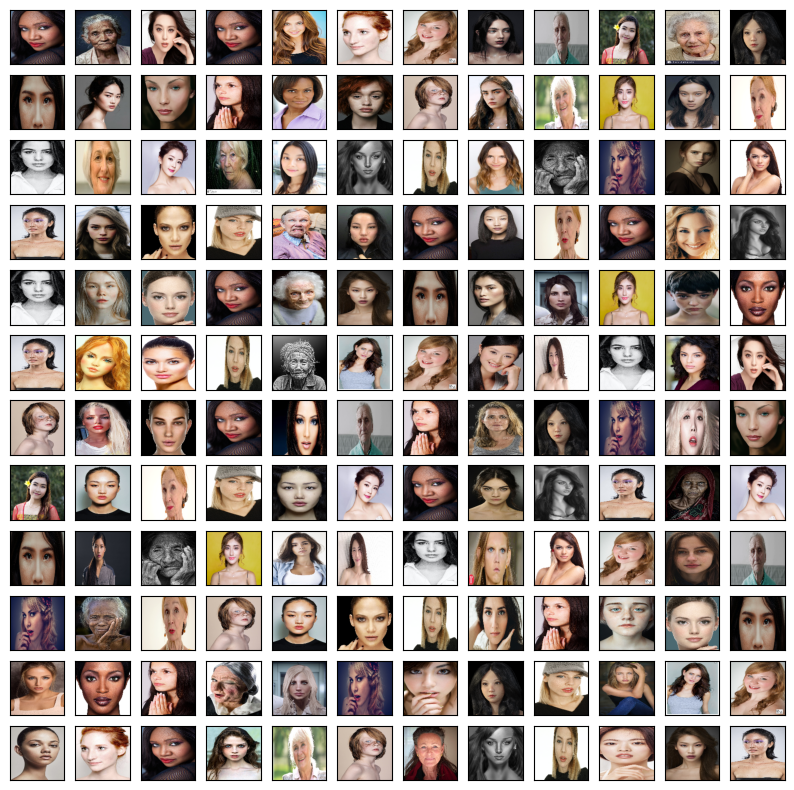

In [40]:
def plot_images(sqr = 5):
    plt.figure(figsize = (10,10))
    plt.title("Real Images",fontsize = 35)
    for i in range(sqr * sqr):
        plt.subplot(sqr,sqr,i+1)
        plt.imshow(_img[i]*0.5 + 0.5 )
        plt.xticks([])
        plt.yticks([])

# to plot images
plot_images(12)

In [6]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(np.array(_img)).batch(batch_size)

latent_dim = 100

def Generator():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(128*128*3, use_bias=False, input_shape=(latent_dim,)))
    model.add(tf.keras.layers.Reshape((128, 128, 3)))
    
    # downsampling
    model.add(tf.keras.layers.Conv2D(128, 4, strides=1, padding='same', kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.Conv2D(128, 4, strides=2, padding='same', kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    
    model.add(tf.keras.layers.Conv2D(256, 4, strides=1, padding='same', kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.Conv2D(256, 4, strides=2, padding='same', kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    
    # upsampling
    model.add(tf.keras.layers.Conv2DTranspose(512, 4, strides=1, padding='same', kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.Conv2D(512, 4, strides=2, padding='same', kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.LeakyReLU())
    
    model.add(tf.keras.layers.Conv2DTranspose(512, 4, strides=1, padding='same', kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.Conv2DTranspose(512, 4, strides=2, padding='same', kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    
    model.add(tf.keras.layers.Conv2DTranspose(256, 4, strides=1, padding='same', kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.Conv2DTranspose(256, 4, strides=2, padding='same', kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    
    model.add(tf.keras.layers.Conv2DTranspose(128, 4, strides=2, padding='same', kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.Conv2DTranspose(128, 4, strides=1, padding='same', kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv2DTranspose(3, 4, strides=1, padding='same', activation='tanh'))
    
    return model

def Discriminator():
    model = tf.keras.Sequential()
    
    model.add(tf.keras.layers.Conv2D(128, 4, strides=2, padding='same', kernel_initializer='he_normal', use_bias=False, input_shape=(SIZE, SIZE, 3)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    
    model.add(tf.keras.layers.Conv2D(128, 4, strides=2, padding='same', kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    
    model.add(tf.keras.layers.Conv2D(256, 4, strides=2, padding='same', kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    
    model.add(tf.keras.layers.Conv2D(256, 4, strides=2, padding='same', kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    
    model.add(tf.keras.layers.Conv2D(512, 4, strides=2, padding='same', kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.LeakyReLU())
    
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    
    return model

In [ ]:
def enhance_image(image, generator_model, latent_dim=100):
    # Normalize the image
    image = (image.astype(np.float32) - 127.5) / 127.5
    image = tf.image.resize(image, [128, 128])  # Resize to 128x128
    image = tf.expand_dims(image, axis=0)  # Add batch dimension
    
    # Generate noise
    noise = tf.random.normal([1, latent_dim])
    
    # Generate enhanced image
    enhanced_image = generator_model.predict(noise)
    
    # Denormalize and clip the image
    enhanced_image = np.clip(enhanced_image[0] * 127.5 + 127.5, 0, 255).astype(np.uint8)
    
    return enhanced_image

In [7]:
optimizer = tf.keras.optimizers.RMSprop(
    learning_rate=.0001,
    clipvalue=1.0
)

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

generator = Generator()
discriminator = Discriminator()

generator.summary()
discriminator.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 49152)             4915200   
                                                                 
 reshape (Reshape)           (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 128)     6144      
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 128)       262144    
                                                                 
 batch_normalization (Batch  (None, 64, 64, 128)       512       
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 128)       0         
                                                      

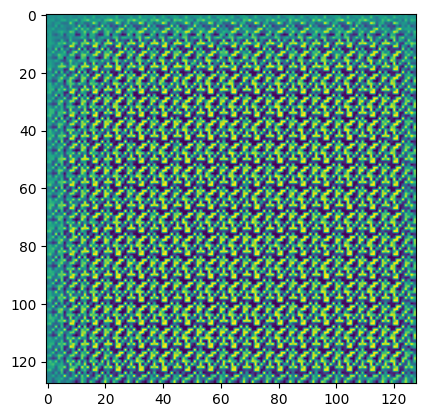

In [23]:
noise = np.random.normal(-1, 1, (1, 100))
img = generator(noise)
plt.imshow(img[0, :, :, 0])
plt.show()

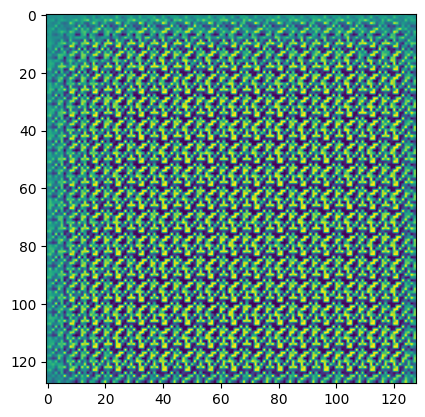

In [24]:
noise = np.random.normal(-1,1,(1,100))
img = generator(noise)
plt.imshow(img[0,:,:,0])
plt.show()

In [25]:
optimizer = tf.keras.optimizers.RMSprop(
    learning_rate=.0001,
    clipvalue=1.0,
    # decay=1e-5
)

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [26]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(fake_output, real_output):
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    return fake_loss + real_loss


In [27]:
def train_steps(images, batch_size, latent_dim, generator, discriminator, generator_loss, discriminator_loss, optimizer):
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise)
        
        fake_output = discriminator(generated_images)
        real_output = discriminator(images)
        
        gen_loss = generator_loss(fake_output)
        dis_loss = discriminator_loss(fake_output, real_output)
        
    gradient_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradient_of_discriminator = disc_tape.gradient(dis_loss, discriminator.trainable_variables)
    
    gradients = gradient_of_generator + gradient_of_discriminator
    variables = generator.trainable_variables + discriminator.trainable_variables
    
    optimizer.apply_gradients(zip(gradients, variables))

    loss = {'gen loss': gen_loss,
            'disc loss': dis_loss}
    
    return loss

def train(epochs, dataset, batch_size, latent_dim, generator, discriminator, generator_loss, discriminator_loss, optimizer):
    for epoch in range(epochs):
        start = time.time()
        print("\nEpoch : {}".format(epoch + 1))
        
        for images in tqdm(dataset):
            loss = train_steps(images, batch_size, latent_dim, generator, discriminator, generator_loss, discriminator_loss, optimizer)
            
        print("Time: {}".format(np.round(time.time() - start), 2)) 
        print("Generator Loss: {} Discriminator Loss: {}".format(loss['gen loss'], loss['disc loss']))



In [28]:
def plot_generated_images(generator, square=5, epochs=0):
    plt.figure(figsize=(10, 10))
    for i in range(square * square):
        if epochs != 0:
            if(i == square // 2):
                plt.title("Generated Image at Epoch:{}\n".format(epochs), fontsize=32, color='black')
        plt.subplot(square, square, i+1)
        noise = np.random.normal(0, 1, (1, latent_dim))
        img = generator(noise)
        plt.imshow(np.clip((img[0, ...]+1)/2, 0, 1))
        
        plt.xticks([])
        plt.yticks([])
        plt.grid()


In [29]:
epochs = 1
train(epochs, dataset, batch_size, latent_dim, generator, discriminator, generator_loss, discriminator_loss, optimizer)



Epoch : 1


  0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 9/9 [13:45<00:00, 91.72s/it] 

Time: 826.0
Generator Loss: 2.6948914527893066 Discriminator Loss: 0.20353597402572632


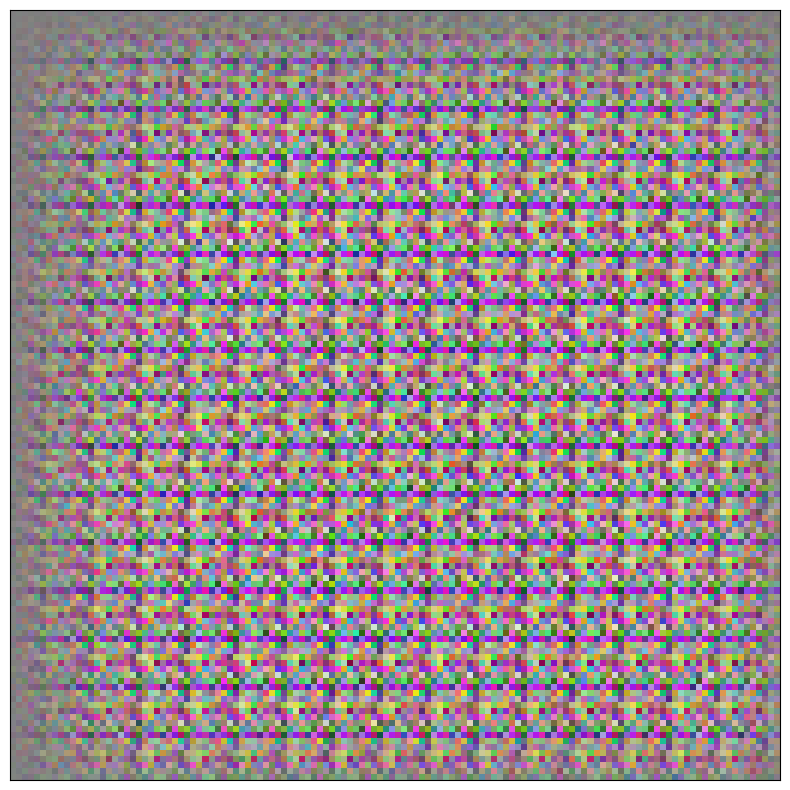

In [43]:
plot_generated_images(generator,1)